This code runs the generalized 3D simulation included in the thesis

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.integrate as integrate
from matplotlib.patches import Rectangle
from numpy import sin, cos, pi, sign
from scipy.integrate import solve_ivp
import scipy.linalg as sc

%matplotlib notebook

In [2]:
# Model parameters
Lp = 0.129      #m
Mp = 0.024      #kg
Jp = 1/12*Mp*Lp**2
Bp = 0.0005

Lr = 0.085
Mr = 0.095 
g = 9.82
Jr = 1/12*Mr*Lr**2
Br = 0.0015

Rm = 8.4
kt = 0.042

dt = 0.05       #Time step, delta t
Tmax = 28
t_span = (0, Tmax)

# Initial conditions
phi0 = 0  
phi0_dot = 0 
theta0 = pi + 0.01
theta0_dot = 0  
state_init = np.array([phi0, phi0_dot, theta0, theta0_dot])

In [3]:
#Constants for the model matrices
T = (Mp*Lr**2+Jr)*(Jp + 1/4*Mp*Lp**2) + 1/4*(Mp*Lp*Lr)**2

a11 = Jp+1/4*Mp*(Lp**2)
a12 = -1/2*Mp*Lp*Lr
a21 = -a12
a22 = Jr + Mp*Lr**2

g0 = g/2*Mp*Lp

In [4]:
#Matrices
A = np.array([
        [0.0,       T,    0.0,     0.0],
        [0.0, -Br*a11, a12*g0, -a12*Bp],
        [0.0,     0.0,    0.0,       T],
        [0.0, -Br*a21, a22*g0,  -Bp*a22]
    ])
A = (1/T)*A

B = np.array([
        [0.0],
        [a11],
        [0.0],
        [a21]
    ])
B = (-kt/(T*Rm))*B   #Rescale to voltage

A_zoh = sc.expm(A*dt)         #Discretize with Zero Order Hold method
B_zoh = integrate.quad_vec(lambda x: sc.expm(A*x)@B, 0, dt)[0] 

In [5]:
N = 30

Q = np.diag([10, 0, 10, 0])  #State cost
R = np.diag([0.1])           #Input cost

QN = np.kron(np.eye(N+1), Q)
RN = np.kron(np.eye(N), R)

In [6]:
F = np.vstack([np.linalg.matrix_power(A_zoh, i) for i in range(N+1)])
G = np.zeros((4*(N+1),N))

for m in range(N+1):
    for n in range(N):
        if m-1-n < 0:
            G[m,n] = 0
        else:
            G[4*m:4*m+4,n] = (np.linalg.matrix_power(A_zoh, m-n-1) @ B_zoh).T

In [7]:
H = G.T@QN@G + RN
f_theta = G.T@QN@F

In [8]:
#Constraints, for details, see the thesis
Ax = np.zeros((6,4))
Ax[0,0], Ax[2,2] = (1,1)
Ax[1,0], Ax[3,2] = (-1,-1)
Ax = np.kron(np.eye(N+1), Ax)

Au = np.array([0,0,0,0,1,-1]).reshape(-1,1)
Au = np.kron(np.eye(N), Au)
Au = np.vstack((Au, np.zeros((6,N))))

b = np.array([pi/2, pi/2, pi/6, pi/6, 10, 10]).reshape(-1,1)
b = np.vstack([b for i in range(N+1)])

In [9]:
A_constraints = Ax@G + Au
W = Ax@F

In [10]:
#SWING UP energy-based

def energy(theta, theta_dot):
    return Jp*(theta_dot**2)/2 + Mp*g*Lp*(cos(theta)-1)

def derivatives(t,state):
    phi,phi_dot,theta,theta_dot = state

    E = energy(theta, theta_dot)
    u = 3*E * theta_dot * cos(theta)
    
    if np.array_equal(state, np.array([0, 0, pi, 0])):    #If the pendulum starts completely still
        u = 10000
        
    u_vector.append(u)

    derivatives = np.array([phi_dot, u, theta_dot, (Mp*Lp*g*sin(theta) - Mp*Lp*u*cos(theta))/Jp])
    return derivatives

def stop_criterion(t, state):           #When to switch to MPC
    _,_,theta,theta_dot = state
    theta_prime = (theta % (2*pi)) - pi
    t1 = abs(theta_prime) > pi-pi/6
    return (t1)*1 - 1

stop_criterion.terminal = True
stop_criterion.direction = 0

In [11]:
#STABILIZE Model Predictive Control

def MPC(init):
    u = cp.Variable((N, 1))
    epsilon = cp.Variable()

    cost = 0.5*(cp.quad_form(u,H)) + ((f_theta@init).T)@u + epsilon**2
    constr = [(Ax@G + Au)@u <= (b-(Ax@F@init)) + epsilon] 

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(verbose=False)

    if prob.status == cp.OPTIMAL:
        ou = np.array((u.value[0, :])).flatten()[0]
    else:
        ou = None

    return ou

In [12]:
def animate_line(i):
    thisx = [x_arm[i], x_rod[i]]
    thisy = [0, y_rod[i]]
    line.set_data(thisx, thisy)
    return line,

def animate_arm(i):
    thisx = [0, x_arm[i]]
    thisy = [0, y_arm[i]]
    arm.set_data(thisx, thisy)
    text.set_text(f"{thetas[i]:.2f}")
    return arm, text

In [13]:
u_vector = []

def create_state_vector():
    #Swing up
    solution = solve_ivp(derivatives, t_span, state_init, events=stop_criterion, max_step=dt)
    state_vector = solution.y.T.tolist()
    
    state_vector[-1][2] = (state_vector[-1][2] + pi) % (2*pi) - pi
    
    #Switch to MPC
    for i in range(len(solution.t), len(solution.t)+30):
        state = np.array(state_vector[i-1]).reshape(-1,1)
        u = MPC(state)
        u_vector.append(u)
        state = np.dot(A_zoh, state) + np.dot(B_zoh, u)
        state_vector.append(state.flatten())
           
    state_vector = np.array(state_vector)
    return state_vector, len(solution.t)+30

In [14]:
#Create state vector
state_vector, t = create_state_vector()

In [15]:
thetas = state_vector[:, 2]
phis = state_vector[:, 0]

x_arm = -sin(phis)*Lr
y_arm = cos(phis)*Lr

x_rod = x_arm-sin(thetas)*Lp
y_rod = cos(thetas)*Lp

<IPython.core.display.Javascript object>


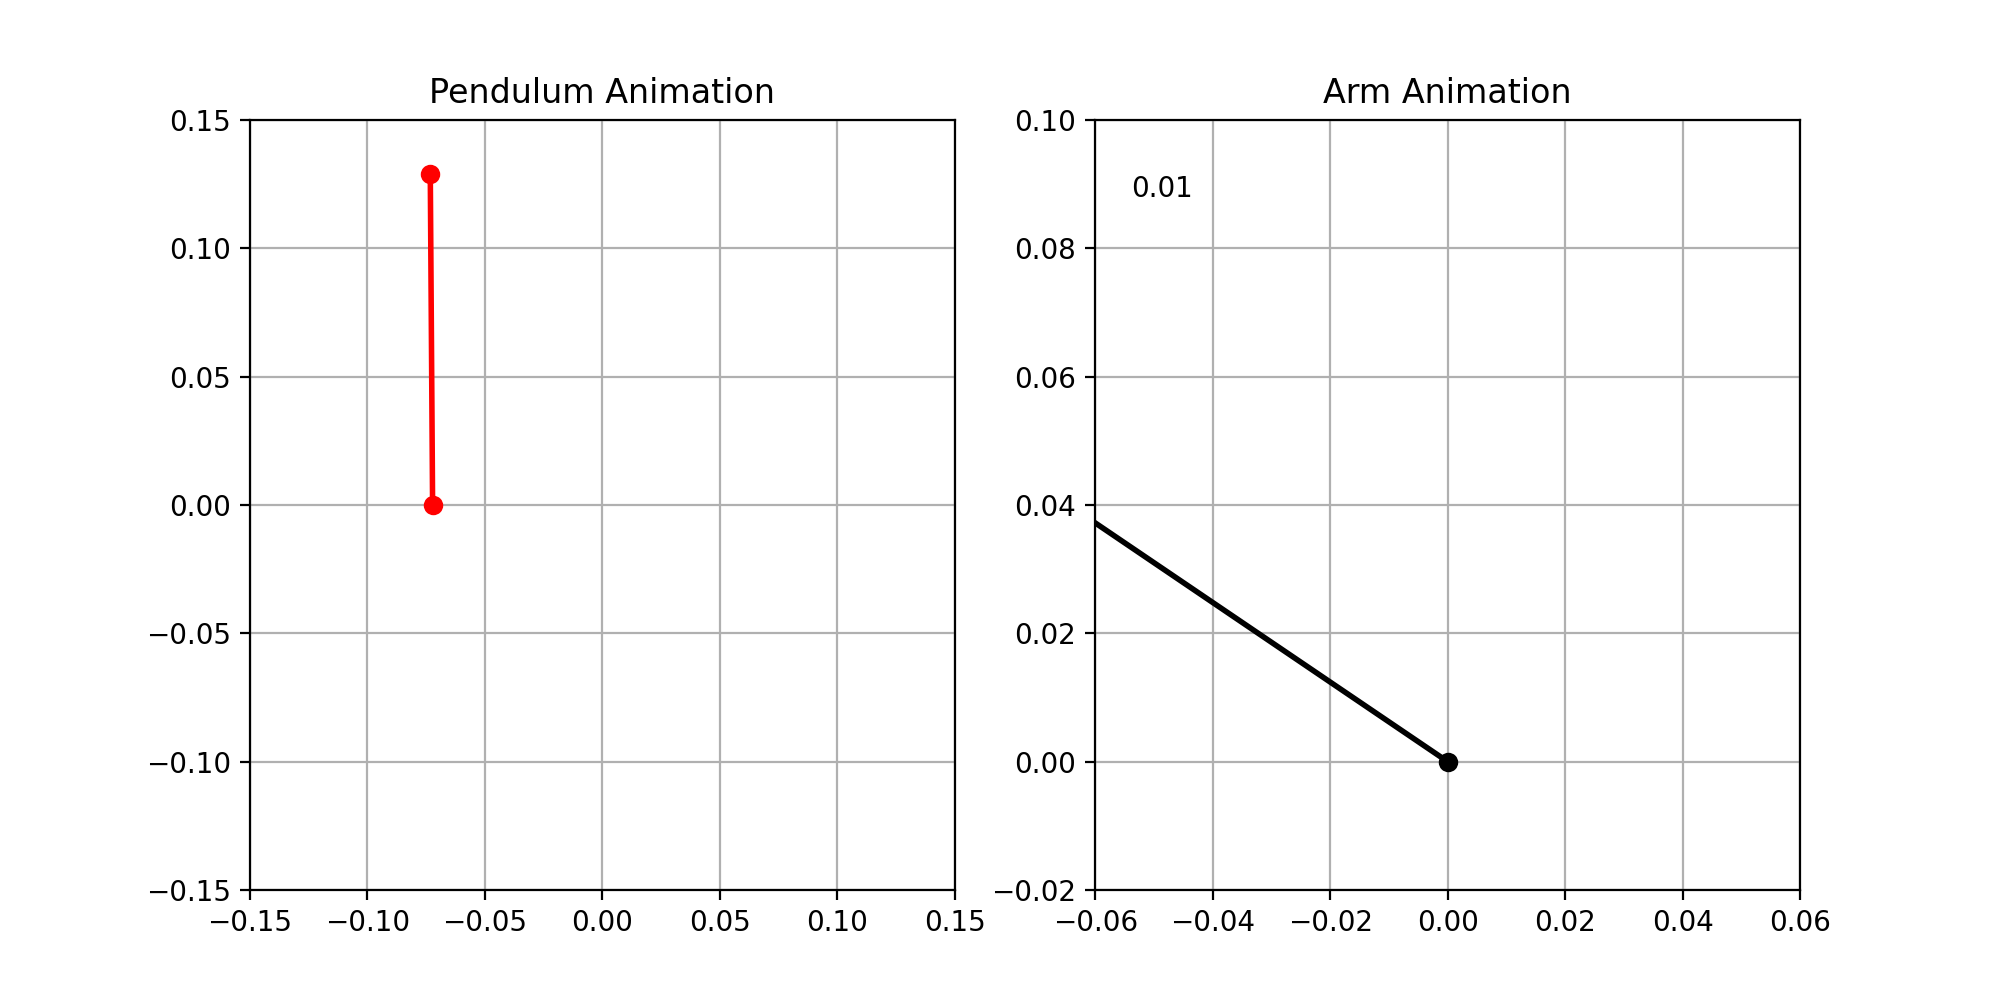

In [16]:
#Simulation, this varies greatly when you change prediciton horizon N or weights Q
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Configure axes
ax1.set_xlim(-0.15, 0.15)
ax1.set_ylim(-0.15, 0.15)
ax1.set_title("Pendulum Animation")
ax1.grid()

ax2.set_xlim(-0.06, 0.06)
ax2.set_ylim(-0.02, 0.1)
ax2.set_title("Arm Animation")
ax2.grid()

text = ax2.text(0.05, 0.9, '', transform=ax2.transAxes)
text.set_text('')

size = 0.2
line, = ax1.plot([], [], 'o-', lw=2, color='red')
arm, = ax2.plot([], [], 'o-', lw=2, color='black')

ani1 = FuncAnimation(fig, animate_line, frames=t, interval=100, blit=True, repeat=False)
ani2 = FuncAnimation(fig, animate_arm, frames=t, interval=100, blit=True, repeat=False)
plt.show()

In [17]:
for i in range(len(state_vector)):
    if state_vector[:,2][i] > pi:
        state_vector[:,2][i] -= 2*pi

<IPython.core.display.Javascript object>


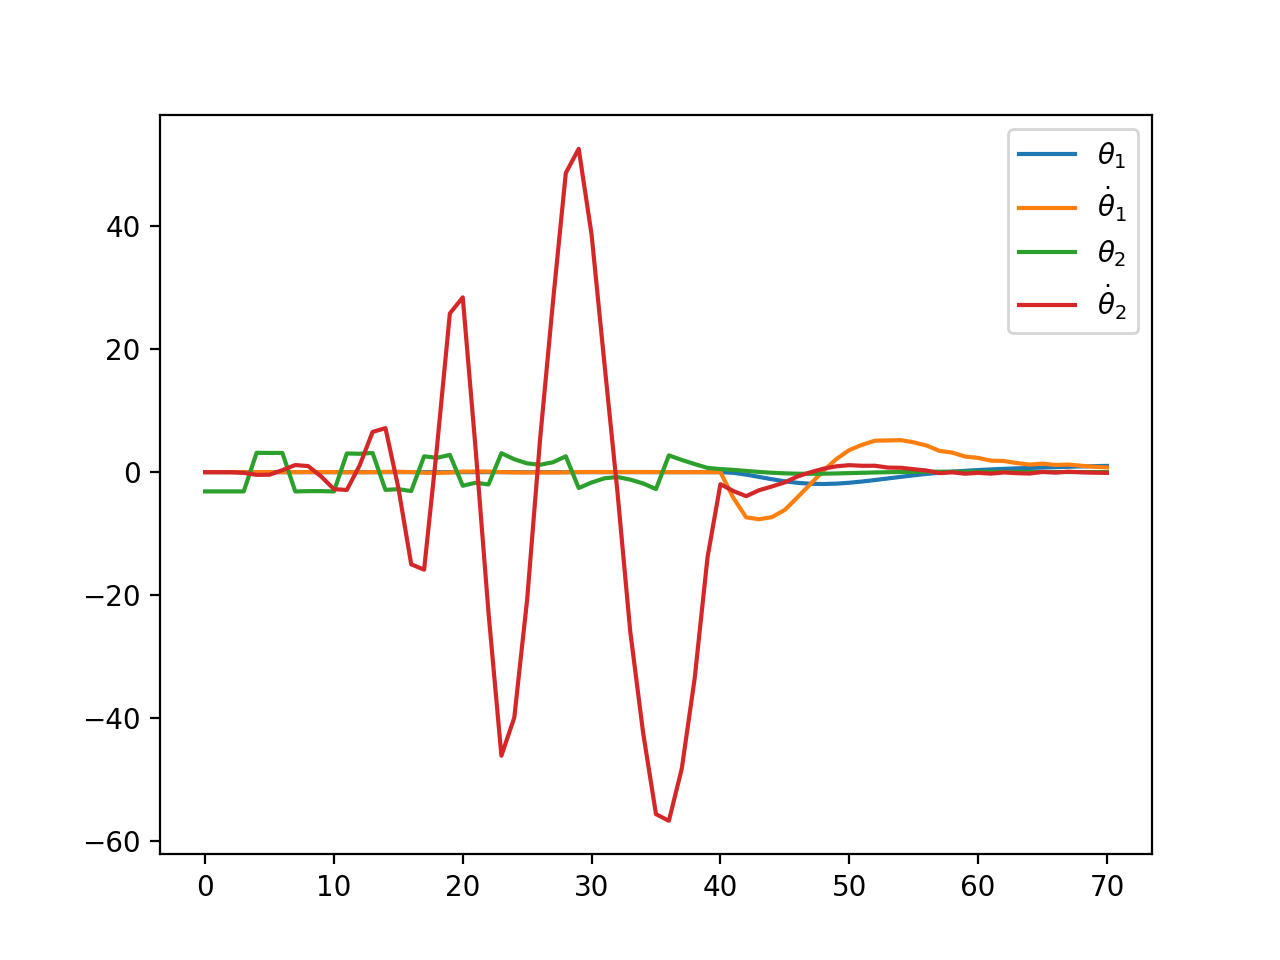

In [19]:
#To make the plot included in the thesis
plt.plot(state_vector)
plt.legend(["$\\theta_1$", "$\\dot{\\theta}_1$", '$\\theta_2$', "$\\dot{\\theta}_2$"])
plt.show()